In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# from torchsampler import ImbalancedDatasetSampler
# from torchmetrics.functional import auroc, precision, recall, f1_score, precision_recall_curve
import albumentations as albu
import albumentations.pytorch
import matplotlib.pyplot as plt
import torchmetrics
import timm
import random

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

## Preprocess data

In [ ]:
def preprocess_df(data_dir):
    df = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
    
#     df['img_path'] = f"{data_dir}/png/png/{df['study_id']}/{df['image_id']}.png"
    
    df['malignancy_label'] = df['breast_birads']
    # Define positive and negatives based on BI-RADS categories
    df.loc[df['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

    # Use pre-defined splits to separate data into development and testing
    train_df = df[df['split'] == 'training']
    test_df = df[df['split'] == 'test']
    
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

def show_image_pair(image1, image2):
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()

def test_dataset(df, idx=0):
    dataset = Dataset(df, data_dir)
    
    img_path = os.path.join(data_dir, 'png/png', dataset.df.iloc[idx]['study_id'], dataset.df.iloc[idx]['image_id'] + '.png')
    image1 = PIL.Image.open(img_path).convert('RGB')

    tensor = dataset[idx].squeeze()
    image2 = torchvision.transforms.ToPILImage()(tensor)

    show_image_pair(image1, image2)

In [ ]:
data_dir = '/kaggle/input/full-fullsize/'

train_df, test_df = preprocess_df(data_dir)
train_df

In [ ]:
# for idx in [random.choice(range(100)) for i in range(3)]:
#     test_dataset(train_df, idx)

### Extract feature

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, model='resnet-18', layer='default', layer_output_size=512):
       
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            # VGG-11
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features # should be 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            # Densenet-121
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features # should be 1024
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            # efficientnet-b0 ~ efficientnet-b7
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [ ]:
def extract_img_feature(df, data_dir, model, vec_length):
    img2vec = Img2Vec(model=model, 
                      layer_output_size=vec_length)
    
    vec_mat = np.zeros((len(df) , vec_length))

    for idx, row in df.iterrows():
        img_path = os.path.join(data_dir, 'png/png', row['study_id'], row['image_id'] + '.png')
        img = PIL.Image.open(img_path).convert('RGB')
        if row['laterality'] == 'L':
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        vec = img2vec.get_vec(img)
        vec_mat[idx, :] = vec
        
    features_df = pd.DataFrame(vec_mat)
    features_df = features_df.add_prefix('feature_')
    features_df['label'] = df['malignancy_label']
    features_df['view_position'] = df['view_position']
    features_df['laterality'] = df['laterality']
    features_df['study_id'] = df['study_id']
    
    return features_df

In [ ]:
model_name = 'efficientnet_b0'
num_features = 1280

features_train = extract_img_feature(df=train_df, 
                                     data_dir=data_dir,
                                     model=model_name, 
                                     vec_length=num_features
                                     )

features_test = extract_img_feature(df=test_df, 
                                    data_dir=data_dir,
                                    model=model_name, 
                                    vec_length=num_features
                                    )

In [ ]:
train_CC = features_train[features_train['view_position'] == 'CC'].drop(['label', 'view_position'], axis=1) 
train_MLO = features_train[features_train['view_position'] == 'MLO'].drop(['view_position'], axis=1) 

test_CC = features_test[features_test['view_position'] == 'CC'].drop(['label', 'view_position'], axis=1) 
test_MLO = features_test[features_test['view_position'] == 'MLO'].drop(['view_position'], axis=1) 

concat_features_train = train_CC.merge(train_MLO, on=['study_id', 'laterality'], suffixes=('_CC', '_MLO'))
concat_features_test = test_CC.merge(test_MLO, on=['study_id', 'laterality'], suffixes=('_CC', '_MLO'))

In [ ]:
concat_features_train

In [ ]:
# concat_features_train.columns

In [ ]:
save_dir = '/kaggle/working/'

concat_features_train.to_csv(f'{save_dir}concat_features_train_{model_name}.csv', index=False)
concat_features_test.to_csv(f'{save_dir}concat_features_test_{model_name}.csv', index=False)

In [ ]:
# Check NaN
print(concat_features_train.isna().any().any())
print(concat_features_test.isna().any().any())

## Classify Model

In [1]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 10.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=82a05b3c82451c05eb1435700e0b5142de9f34b6e512a011d359aab6442eb3e7
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [2]:
import skfuzzy as fuzz
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.metrics import roc_curve,precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

import os
import numpy as np
import pandas as pd

In [12]:
concat_features_train = pd.read_csv('/kaggle/input/vin-feature/concat_features_train_efficientnet_b0.csv')
concat_features_test = pd.read_csv('/kaggle/input/vin-feature/concat_features_test_efficientnet_b0.csv')

concat_features_train

,feature_0_CC,feature_1_CC,feature_2_CC,feature_3_CC,feature_4_CC,feature_5_CC,feature_6_CC,feature_7_CC,feature_8_CC,feature_9_CC,...,feature_1271_MLO,feature_1272_MLO,feature_1273_MLO,feature_1274_MLO,feature_1275_MLO,feature_1276_MLO,feature_1277_MLO,feature_1278_MLO,feature_1279_MLO,label
0,-0.101210,-0.174239,0.121421,-0.141098,-0.277888,-0.186682,-0.140499,-0.067732,-0.111569,-0.269176,...,-0.227731,-0.069607,-0.245696,-0.261152,0.777141,-0.277788,0.419119,-0.137479,-0.125389,0
1,-0.058023,-0.144134,0.043329,-0.205208,-0.277090,-0.239452,-0.136032,-0.068292,-0.111630,-0.277913,...,-0.267062,-0.045241,0.110348,-0.278391,1.332054,-0.129526,-0.214615,-0.171379,-0.265228,0
2,-0.133359,-0.116345,-0.090174,-0.152623,-0.274790,-0.261249,-0.108648,-0.066531,-0.120386,-0.276416,...,-0.229044,-0.099550,-0.273775,-0.276369,-0.198178,-0.078316,-0.242274,-0.114382,-0.211536,0
3,-0.028937,-0.137982,-0.021677,-0.123771,-0.278450,-0.276996,-0.113804,-0.076267,-0.138271,-0.278445,...,-0.215473,-0.081372,-0.271739,-0.271640,-0.221536,-0.068043,-0.256326,-0.115784,-0.235606,0
4,-0.237625,-0.103890,-0.161415,-0.151816,-0.258543,-0.255977,-0.122566,-0.094943,-0.183906,-0.223354,...,-0.171533,-0.156897,-0.103236,0.013147,-0.208144,-0.277218,-0.196322,-0.128612,-0.212763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,-0.258254,-0.080930,0.449778,-0.089230,-0.240298,-0.196373,-0.084969,-0.056243,-0.064630,-0.259314,...,-0.224987,-0.070554,-0.268184,-0.209462,-0.272872,-0.250021,-0.247301,-0.076688,-0.267579,0
7995,-0.065698,-0.121744,-0.142756,-0.103660,-0.277657,-0.269506,-0.077604,-0.117808,-0.209393,-0.276863,...,-0.248899,-0.061061,-0.270626,0.856457,-0.182576,-0.219728,-0.203649,-0.137060,-0.168686,0
7996,-0.258811,-0.164959,-0.137258,-0.115478,-0.265617,-0.250546,-0.094390,-0.146150,-0.200458,-0.257736,...,-0.119826,-0.057346,-0.202150,-0.243588,-0.253669,-0.193268,-0.087486,-0.161627,-0.272322,0
7997,-0.107519,-0.185627,0.245910,-0.104862,-0.278052,-0.061016,-0.138582,-0.048616,-0.064193,-0.246309,...,-0.125756,-0.156107,-0.262996,-0.273179,1.193740,-0.097256,-0.161601,-0.047568,-0.126142,0


In [13]:
X_train = concat_features_train.copy().drop(['label', 'study_id', 'laterality'], axis=1)  # Features
y_train = np.array(concat_features_train['label']).astype(int)
X_test = concat_features_test.copy().drop(['label', 'study_id', 'laterality'], axis=1)  # Features
y_test = np.array(concat_features_test['label']).astype(int)

In [14]:
X_train

,feature_0_CC,feature_1_CC,feature_2_CC,feature_3_CC,feature_4_CC,feature_5_CC,feature_6_CC,feature_7_CC,feature_8_CC,feature_9_CC,...,feature_1270_MLO,feature_1271_MLO,feature_1272_MLO,feature_1273_MLO,feature_1274_MLO,feature_1275_MLO,feature_1276_MLO,feature_1277_MLO,feature_1278_MLO,feature_1279_MLO
0,-0.101210,-0.174239,0.121421,-0.141098,-0.277888,-0.186682,-0.140499,-0.067732,-0.111569,-0.269176,...,-0.219428,-0.227731,-0.069607,-0.245696,-0.261152,0.777141,-0.277788,0.419119,-0.137479,-0.125389
1,-0.058023,-0.144134,0.043329,-0.205208,-0.277090,-0.239452,-0.136032,-0.068292,-0.111630,-0.277913,...,-0.066708,-0.267062,-0.045241,0.110348,-0.278391,1.332054,-0.129526,-0.214615,-0.171379,-0.265228
2,-0.133359,-0.116345,-0.090174,-0.152623,-0.274790,-0.261249,-0.108648,-0.066531,-0.120386,-0.276416,...,-0.269503,-0.229044,-0.099550,-0.273775,-0.276369,-0.198178,-0.078316,-0.242274,-0.114382,-0.211536
3,-0.028937,-0.137982,-0.021677,-0.123771,-0.278450,-0.276996,-0.113804,-0.076267,-0.138271,-0.278445,...,-0.274468,-0.215473,-0.081372,-0.271739,-0.271640,-0.221536,-0.068043,-0.256326,-0.115784,-0.235606
4,-0.237625,-0.103890,-0.161415,-0.151816,-0.258543,-0.255977,-0.122566,-0.094943,-0.183906,-0.223354,...,-0.238900,-0.171533,-0.156897,-0.103236,0.013147,-0.208144,-0.277218,-0.196322,-0.128612,-0.212763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,-0.258254,-0.080930,0.449778,-0.089230,-0.240298,-0.196373,-0.084969,-0.056243,-0.064630,-0.259314,...,-0.276627,-0.224987,-0.070554,-0.268184,-0.209462,-0.272872,-0.250021,-0.247301,-0.076688,-0.267579
7995,-0.065698,-0.121744,-0.142756,-0.103660,-0.277657,-0.269506,-0.077604,-0.117808,-0.209393,-0.276863,...,-0.278353,-0.248899,-0.061061,-0.270626,0.856457,-0.182576,-0.219728,-0.203649,-0.137060,-0.168686
7996,-0.258811,-0.164959,-0.137258,-0.115478,-0.265617,-0.250546,-0.094390,-0.146150,-0.200458,-0.257736,...,-0.278436,-0.119826,-0.057346,-0.202150,-0.243588,-0.253669,-0.193268,-0.087486,-0.161627,-0.272322
7997,-0.107519,-0.185627,0.245910,-0.104862,-0.278052,-0.061016,-0.138582,-0.048616,-0.064193,-0.246309,...,-0.251418,-0.125756,-0.156107,-0.262996,-0.273179,1.193740,-0.097256,-0.161601,-0.047568,-0.126142


In [15]:
num_select_feature = int(X_train.shape[1]*0.1)
mi_selector = SelectKBest(mutual_info_classif, k=num_select_feature)

# Transform the data
X_selected = mi_selector.fit_transform(X_train, y_train)

In [16]:
X_selected.shape

(7999, 256)

### Classifier

In [26]:
# Perform Fuzzy C-Means clustering using skfuzzy
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_selected.T, c=2,
                                                 m=2.5, error=0.005, maxiter=10000)

### Get predictions

In [27]:
# Transform the data
X_test_selected = mi_selector.fit_transform(X_test, y_test)

# Predict using the test set
u_test, _, _, _, _, _ = fuzz.cluster.cmeans_predict(X_test_selected.T, cntr, 
                                                    m=2.5, error=0.005, maxiter=10000)
print(u_test)

# Get the most likely class for each sample
y_pred = np.argmax(u_test, axis=0)
print(y_pred)

[[0.499934   0.49990528 0.49989871 ... 0.49997143 0.49978226 0.49978799]
 [0.500066   0.50009472 0.50010129 ... 0.50002857 0.50021774 0.50021201]]
[1 1 1 ... 1 1 1]


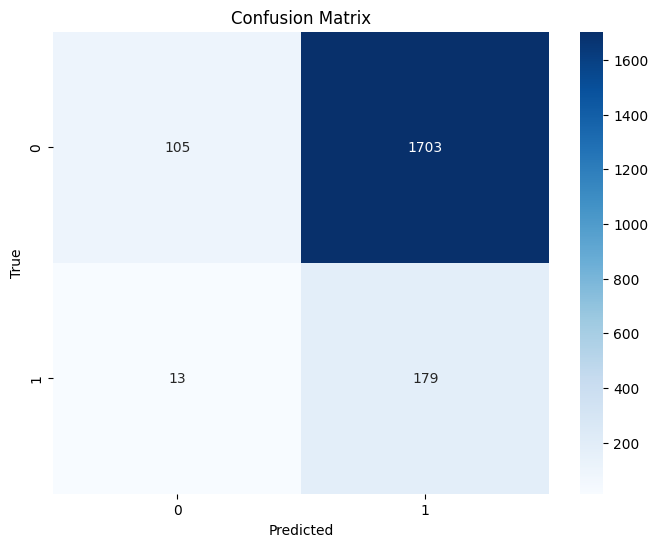

              precision    recall  f1-score   support

           0       0.89      0.06      0.11      1808
           1       0.10      0.93      0.17       192

    accuracy                           0.14      2000
   macro avg       0.49      0.50      0.14      2000
weighted avg       0.81      0.14      0.12      2000



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize=None)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
report = classification_report(y_test, y_pred)
print(report)

In [25]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')
test_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", test_accuracy)
print('Precison:', test_precision)
print('Recall:', test_recall)
print('F1 Score:', test_f1)
print('AUC:', test_auc)

Accuracy: 0.142
Precison: 0.49247104594823393
Recall: 0.49518344395280234
F1 Score: 0.1408237877654509
AUC: 0.49518344395280234
